Copyright by Arjun Sarkar Research Group Applied Systems Biology - Head: Prof. Dr. Marc Thilo Figge https://www.leibniz-hki.de/en/applied-systems-biology.html HKI-Center for Systems Biology of Infection Leibniz Institute for Natural Product Research and Infection Biology - Hans Knöll Insitute (HKI) Adolf-Reichwein-Straße 23, 07745 Jena, Germany

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2 as cv
import math

from sklearn import preprocessing
import datetime

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50, preprocess_input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau

from sklearn.model_selection import train_test_split

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="6"

strategy = tf.distribute.MirroredStrategy(["GPU:0"])

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [3]:
df = pd.read_csv('Label_Training.csv')
df.head()

,video_num,image,infection,patient,class_label,image_path
0,1,246.tif,ca,1,0,/asbdata/Arjun/Bloodi/TIFF8/1/246.tif
1,1,094.tif,ca,1,0,/asbdata/Arjun/Bloodi/TIFF8/1/094.tif
2,1,158.tif,ca,1,0,/asbdata/Arjun/Bloodi/TIFF8/1/158.tif
3,1,062.tif,ca,1,0,/asbdata/Arjun/Bloodi/TIFF8/1/062.tif
4,1,174.tif,ca,1,0,/asbdata/Arjun/Bloodi/TIFF8/1/174.tif


In [4]:
test = df[(df['patient']==7)]
test

,video_num,image,infection,patient,class_label,image_path
2340,18,246.tif,ca,7,0,/asbdata/Arjun/Bloodi/TIFF8/18/246.tif
2341,18,094.tif,ca,7,0,/asbdata/Arjun/Bloodi/TIFF8/18/094.tif
2342,18,158.tif,ca,7,0,/asbdata/Arjun/Bloodi/TIFF8/18/158.tif
2343,18,062.tif,ca,7,0,/asbdata/Arjun/Bloodi/TIFF8/18/062.tif
2344,18,174.tif,ca,7,0,/asbdata/Arjun/Bloodi/TIFF8/18/174.tif
...,...,...,...,...,...,...
3115,20,177.tif,mock,7,2,/asbdata/Arjun/Bloodi/TIFF8/20/177.tif
3116,20,066.tif,mock,7,2,/asbdata/Arjun/Bloodi/TIFF8/20/066.tif
3117,20,042.tif,mock,7,2,/asbdata/Arjun/Bloodi/TIFF8/20/042.tif
3118,20,250.tif,mock,7,2,/asbdata/Arjun/Bloodi/TIFF8/20/250.tif


In [5]:
Xtrain = pd.concat([df, test]).drop_duplicates(keep=False)
Xtrain

,video_num,image,infection,patient,class_label,image_path
0,1,246.tif,ca,1,0,/asbdata/Arjun/Bloodi/TIFF8/1/246.tif
1,1,094.tif,ca,1,0,/asbdata/Arjun/Bloodi/TIFF8/1/094.tif
2,1,158.tif,ca,1,0,/asbdata/Arjun/Bloodi/TIFF8/1/158.tif
3,1,062.tif,ca,1,0,/asbdata/Arjun/Bloodi/TIFF8/1/062.tif
4,1,174.tif,ca,1,0,/asbdata/Arjun/Bloodi/TIFF8/1/174.tif
...,...,...,...,...,...,...
7015,35,177.tif,mock,12,2,/asbdata/Arjun/Bloodi/TIFF8/35/177.tif
7016,35,066.tif,mock,12,2,/asbdata/Arjun/Bloodi/TIFF8/35/066.tif
7017,35,042.tif,mock,12,2,/asbdata/Arjun/Bloodi/TIFF8/35/042.tif
7018,35,250.tif,mock,12,2,/asbdata/Arjun/Bloodi/TIFF8/35/250.tif


In [6]:
train, val = train_test_split(Xtrain, test_size=0.2, stratify = Xtrain['class_label'], random_state=42)
train

,video_num,image,infection,patient,class_label,image_path
542,3,186.tif,mock,1,2,/asbdata/Arjun/Bloodi/TIFF8/3/186.tif
3459,22,178.tif,cg,8,1,/asbdata/Arjun/Bloodi/TIFF8/22/178.tif
3528,22,107.tif,cg,8,1,/asbdata/Arjun/Bloodi/TIFF8/22/107.tif
888,4,142.tif,ca,2,0,/asbdata/Arjun/Bloodi/TIFF8/4/142.tif
4519,26,197.tif,mock,9,2,/asbdata/Arjun/Bloodi/TIFF8/26/197.tif
...,...,...,...,...,...,...
2231,15,140.tif,mock,5,2,/asbdata/Arjun/Bloodi/TIFF8/15/140.tif
902,4,189.tif,ca,2,0,/asbdata/Arjun/Bloodi/TIFF8/4/189.tif
6588,34,115.tif,cg,12,1,/asbdata/Arjun/Bloodi/TIFF8/34/115.tif
4264,25,179.tif,cg,9,1,/asbdata/Arjun/Bloodi/TIFF8/25/179.tif


In [7]:
val

,video_num,image,infection,patient,class_label,image_path
5852,31,069.tif,cg,11,1,/asbdata/Arjun/Bloodi/TIFF8/31/069.tif
6462,33,056.tif,ca,12,0,/asbdata/Arjun/Bloodi/TIFF8/33/056.tif
1273,5,233.tif,cg,2,1,/asbdata/Arjun/Bloodi/TIFF8/5/233.tif
3211,21,051.tif,ca,8,0,/asbdata/Arjun/Bloodi/TIFF8/21/051.tif
926,4,039.tif,ca,2,0,/asbdata/Arjun/Bloodi/TIFF8/4/039.tif
...,...,...,...,...,...,...
3924,24,098.tif,ca,9,0,/asbdata/Arjun/Bloodi/TIFF8/24/098.tif
5908,31,103.tif,cg,11,1,/asbdata/Arjun/Bloodi/TIFF8/31/103.tif
4352,25,072.tif,cg,9,1,/asbdata/Arjun/Bloodi/TIFF8/25/072.tif
3929,24,161.tif,ca,9,0,/asbdata/Arjun/Bloodi/TIFF8/24/161.tif


In [8]:
image_size = 512
batch_size = 16

def get_train_generator(df, x_col, y_cols, shuffle=True, batch_size=batch_size, seed=1, image_size=image_size):

    # normalize images
    image_generator = ImageDataGenerator(preprocessing_function=preprocess_input,
                                        horizontal_flip=True,
                                        vertical_flip=True)
    
    # flow from directory with specified batch size
    # and target image size
    generator = image_generator.flow_from_dataframe(
            dataframe=df,
            directory=None,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            target_size=(image_size,image_size),
            shuffle=False,
            seed=seed)
    
    return generator

def get_test_and_valid_generator(valid_df, test_df, x_col, y_cols, batch_size=batch_size, seed=1, image_size=image_size):

    image_generator = ImageDataGenerator(preprocessing_function=preprocess_input)


    # get test generator
    valid_generator = image_generator.flow_from_dataframe(
            dataframe=valid_df,
            directory=None,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            target_size = (image_size,image_size),
            shuffle=False,
            seed=seed)
    
    test_generator = image_generator.flow_from_dataframe(
            dataframe=test_df,
            directory=None,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            target_size = (image_size,image_size),
            shuffle=False,
            seed=seed)
    
    return valid_generator, test_generator

In [9]:
train_generator = get_train_generator(train, 'image_path', 'class_label')
valid_generator, test_generator= get_test_and_valid_generator(val, test, 'image_path','class_label')

Found 4992 validated image filenames.
Found 1248 validated image filenames.
Found 780 validated image filenames.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


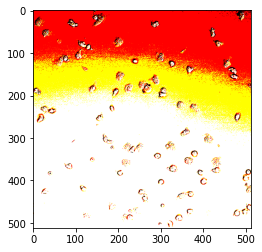

In [10]:
x, y = train_generator.__getitem__(3)
plt.imshow(x[0])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


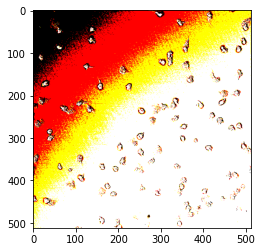

In [11]:
x, y = valid_generator.__getitem__(3)
plt.imshow(x[0])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


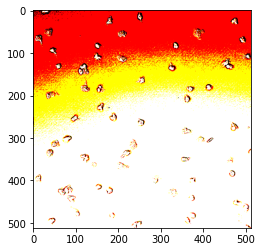

In [12]:
x, y = test_generator.__getitem__(3)
plt.imshow(x[0])
plt.show()

In [13]:
with strategy.scope():
    
    inputs = Input(shape=(image_size,image_size, 3))
    base_model = ResNet50 (weights = 'imagenet',include_top=False, input_tensor=inputs)

    # add a global spatial average pooling layer
    x = GlobalAveragePooling2D()(base_model.output)

    x = Dense(1024, kernel_regularizer=l2(0.0003),activation='relu')(x)
    x = Dropout(0.5)(x)

    # and a logistic layer
    predictions = Dense(3, activation="softmax")(x)
    
    model = Model(inputs=inputs, outputs=predictions)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(), 
                  loss="sparse_categorical_crossentropy", 
                  metrics=["accuracy"])

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 518, 518, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 256, 256, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

 conv2_block2_add (Add)         (None, 128, 128, 25  0           ['conv2_block1_out[0][0]',       
                                6)                                'conv2_block2_3_bn[0][0]']      
                                                                                                  
 conv2_block2_out (Activation)  (None, 128, 128, 25  0           ['conv2_block2_add[0][0]']       
                                6)                                                                
                                                                                                  
 conv2_block3_1_conv (Conv2D)   (None, 128, 128, 64  16448       ['conv2_block2_out[0][0]']       
                                )                                                                 
                                                                                                  
 conv2_block3_1_bn (BatchNormal  (None, 128, 128, 64  256        ['conv2_block3_1_conv[0][0]']    
 ization) 

 conv3_block2_3_conv (Conv2D)   (None, 64, 64, 512)  66048       ['conv3_block2_2_relu[0][0]']    
                                                                                                  
 conv3_block2_3_bn (BatchNormal  (None, 64, 64, 512)  2048       ['conv3_block2_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_add (Add)         (None, 64, 64, 512)  0           ['conv3_block1_out[0][0]',       
                                                                  'conv3_block2_3_bn[0][0]']      
                                                                                                  
 conv3_block2_out (Activation)  (None, 64, 64, 512)  0           ['conv3_block2_add[0][0]']       
                                                                                                  
 conv3_blo

                                                                                                  
 conv4_block1_0_bn (BatchNormal  (None, 32, 32, 1024  4096       ['conv4_block1_0_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 conv4_block1_3_bn (BatchNormal  (None, 32, 32, 1024  4096       ['conv4_block1_3_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 conv4_block1_add (Add)         (None, 32, 32, 1024  0           ['conv4_block1_0_bn[0][0]',      
                                )                                 'conv4_block1_3_bn[0][0]']      
                                                                                                  
 conv4_blo

 n)                                                                                               
                                                                                                  
 conv4_block4_3_conv (Conv2D)   (None, 32, 32, 1024  263168      ['conv4_block4_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv4_block4_3_bn (BatchNormal  (None, 32, 32, 1024  4096       ['conv4_block4_3_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 conv4_block4_add (Add)         (None, 32, 32, 1024  0           ['conv4_block3_out[0][0]',       
                                )                                 'conv4_block4_3_bn[0][0]']      
          

 conv5_block1_2_relu (Activatio  (None, 16, 16, 512)  0          ['conv5_block1_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block1_0_conv (Conv2D)   (None, 16, 16, 2048  2099200     ['conv4_block6_out[0][0]']       
                                )                                                                 
                                                                                                  
 conv5_block1_3_conv (Conv2D)   (None, 16, 16, 2048  1050624     ['conv5_block1_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv5_block1_0_bn (BatchNormal  (None, 16, 16, 2048  8192       ['conv5_block1_0_conv[0][0]']    
 ization) 

 dropout (Dropout)              (None, 1024)         0           ['dense[0][0]']                  
                                                                                                  
 dense_1 (Dense)                (None, 3)            3075        ['dropout[0][0]']                
                                                                                                  
Total params: 25,688,963
Trainable params: 25,635,843
Non-trainable params: 53,120
__________________________________________________________________________________________________


In [15]:
lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)

stopping = EarlyStopping(monitor='val_loss', patience=5)

callbacks = ModelCheckpoint('resnet_fullimage_test_4.h5', 
                            monitor='val_loss', save_best_only=True, mode = 'auto')

In [16]:
history = model.fit(train_generator, 
                              validation_data=valid_generator,
                              epochs = 10,
                              callbacks = [callbacks,lr_schedule,stopping])

Epoch 1/10
312/312 [==============================] - 384s 1s/step - loss: 0.6830 - accuracy: 0.8592 - val_loss: 282.7280 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 2/10
312/312 [==============================] - 358s 1s/step - loss: 0.3260 - accuracy: 0.9477 - val_loss: 5.9250 - val_accuracy: 0.6354 - lr: 0.0010
Epoch 3/10
312/312 [==============================] - 349s 1s/step - loss: 0.2130 - accuracy: 0.9645 - val_loss: 0.1575 - val_accuracy: 0.9704 - lr: 0.0010
Epoch 4/10
312/312 [==============================] - 357s 1s/step - loss: 0.1670 - accuracy: 0.9688 - val_loss: 3.4313 - val_accuracy: 0.7115 - lr: 0.0010
Epoch 5/10
312/312 [==============================] - 355s 1s/step - loss: 0.1204 - accuracy: 0.9768 - val_loss: 6.9947 - val_accuracy: 0.5721 - lr: 0.0010
Epoch 6/10
312/312 [==============================] - 357s 1s/step - loss: 0.1004 - accuracy: 0.9786 - val_loss: 0.3550 - val_accuracy: 0.8942 - lr: 0.0010
Epoch 7/10
312/312 [==============================] - 359s 1s/

In [17]:
final_model = tf.keras.models.load_model('resnet_fullimage_test_4.h5')

In [18]:
predicted = final_model.predict(test_generator, steps = len(test_generator)).argmax(axis=1)

49/49 [==============================] - 46s 921ms/step


In [19]:
test_labels = test['class_label']
test_labels = np.array(test_labels)

In [20]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

([<matplotlib.axis.YTick at 0x7f749068ebe0>,
 [Text(0, 0, 'ca'), Text(0, 1, 'cg'), Text(0, 2, 'mock')])

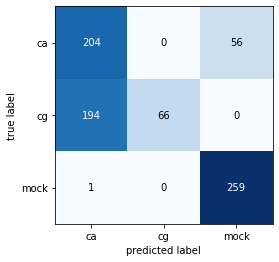

In [21]:
labels = ['ca','cg','mock']

matrix = confusion_matrix (test_labels,predicted)
plot_confusion_matrix(matrix, figsize=(4,4))
plt.xticks(range(3),labels, fontsize=10)
plt.yticks(range(3),labels, fontsize=10)